<a href="https://colab.research.google.com/github/IANGECHUKI176/deeplearning/blob/main/pytorch/gans/aae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Adversarial Autoencoders](https://arxiv.org/pdf/1511.05644.pdf)

In [19]:
import torch
import torch.nn as nn
from torchvision import datasets , transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import numpy as np
import math
import itertools
from torchsummary import summary
from tqdm import tqdm
import matplotlib.pyplot as plt


In [20]:
n_epochs = 200
batch_size = 64
lr = 0.0002
b1 = 0.5
b2 = 0.999
latent_dim = 10
img_size = 32
channels = 1
display_step = 5000
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
img_shape = (channels,img_size,img_size)

In [21]:
def reparameterization(mu,logvar):
    std = torch.exp(logvar/2)
    eps = torch.randn(mu.size(0),latent_dim,device = mu.device)
    z = eps * std + mu
    return z

In [22]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)),512),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2,inplace = True)
        )
        self.mu = nn.Linear(512,latent_dim)
        self.logvar = nn.Linear(512,latent_dim)

    def forward(self,img):
        img_flat = img.view(img.size(0),-1)
        x = self.model(img_flat)
        mu = self.mu(x)
        logvar = self.logvar(x)
        z = reparameterization(mu,logvar)
        return z

In [23]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim,512),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Linear(512,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Linear(512,int(np.prod(img_shape))),
            nn.Tanh()
        )
    def forward(self,z):
        img_flat = self.model(z)
        img = img_flat.view(img_flat.size(0),*img_shape)
        return img

In [24]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim,512),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2,inplace = True),
            nn.Linear(256,1),
            nn.Sigmoid()
        )

    def forward(self,z):
        validity = self.model(z)
        return validity

In [25]:
#use binary cross entropy loss
adversarial_loss = nn.BCELoss()
pixelwiseloss = nn.L1Loss()

In [26]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
discriminator = Discriminator().to(device)


In [27]:
dataloader = DataLoader(
    datasets.MNIST(
        './root',
        download = True,
        train = True,
        transform = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            transforms.Normalize([0.5],[0.5])
        ])
        ),
    batch_size = batch_size,
    shuffle = True
)

In [28]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

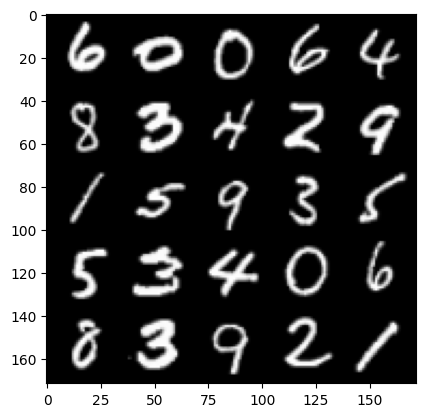

In [29]:

images,labels = next(iter(dataloader))
show_tensor_images(images)

In [30]:
optimizer_G = torch.optim.Adam(itertools.chain(
    encoder.parameters(),
    decoder.parameters()),lr = lr ,betas = (b1,b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(),lr = lr,betas = (b1,b2))

 33%|███▎      | 306/938 [00:07<00:15, 41.73it/s]

Epoch 5, step 5000: Generator loss: 0.07452570547536032, discriminator loss: 0.07452570547536032
-------------------fake images------------------------


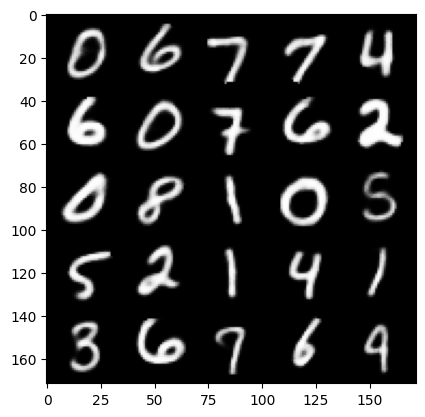

-------------------fake images------------------------


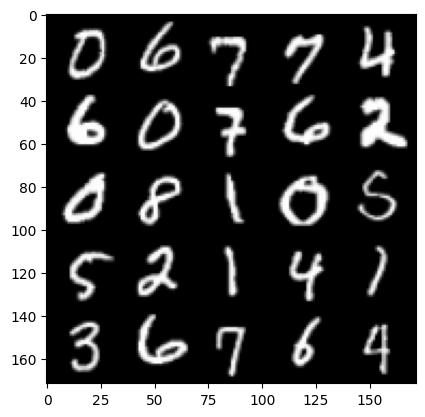

 66%|██████▌   | 618/938 [00:17<00:08, 39.16it/s]

Epoch 10, step 10000: Generator loss: 0.07348036547601212, discriminator loss: 0.07348036547601212
-------------------fake images------------------------


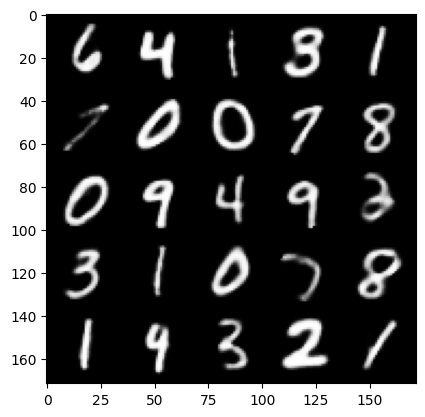

-------------------fake images------------------------


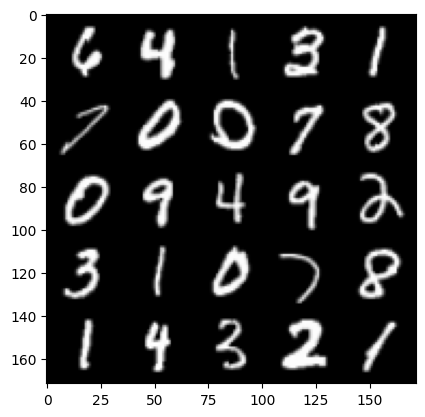

 99%|█████████▉| 929/938 [00:24<00:00, 40.99it/s]

Epoch 15, step 15000: Generator loss: 0.0725535332992671, discriminator loss: 0.0725535332992671
-------------------fake images------------------------


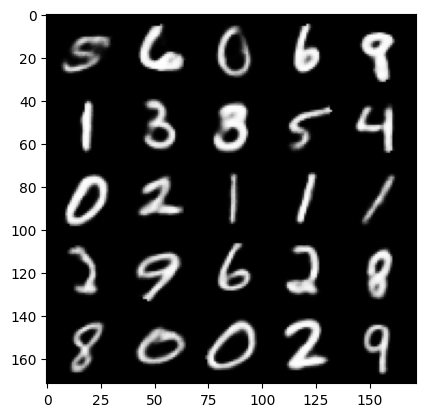

-------------------fake images------------------------


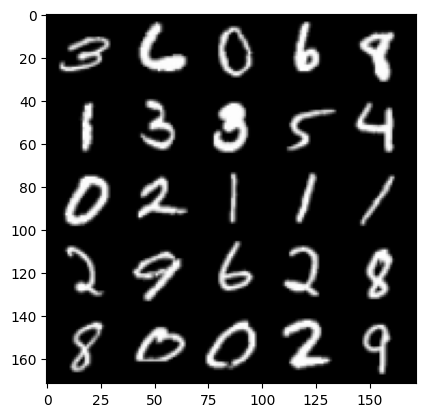

 32%|███▏      | 298/938 [00:07<00:15, 41.48it/s]

Epoch 21, step 20000: Generator loss: 0.07179310709089047, discriminator loss: 0.07179310709089047
-------------------fake images------------------------


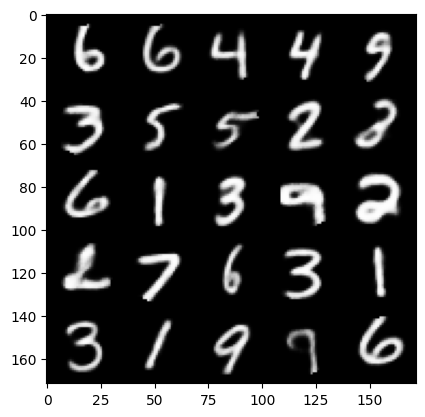

-------------------fake images------------------------


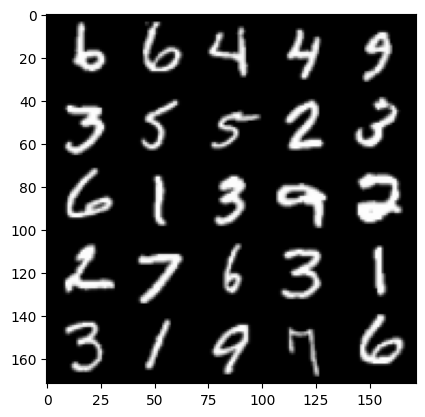

 65%|██████▍   | 609/938 [00:17<00:08, 37.57it/s]

Epoch 26, step 25000: Generator loss: 0.07108991693109272, discriminator loss: 0.07108991693109272
-------------------fake images------------------------


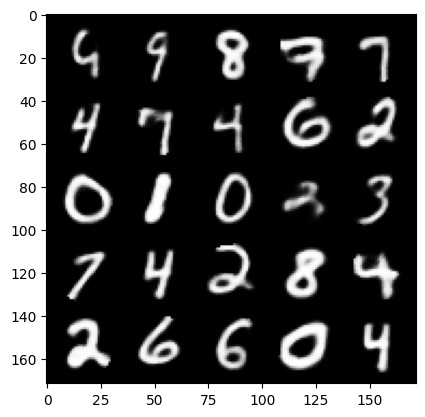

-------------------fake images------------------------


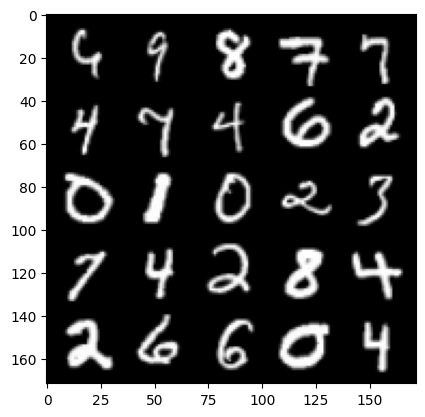

 98%|█████████▊| 920/938 [00:24<00:00, 29.37it/s]

Epoch 31, step 30000: Generator loss: 0.07052727807909254, discriminator loss: 0.07052727807909254
-------------------fake images------------------------


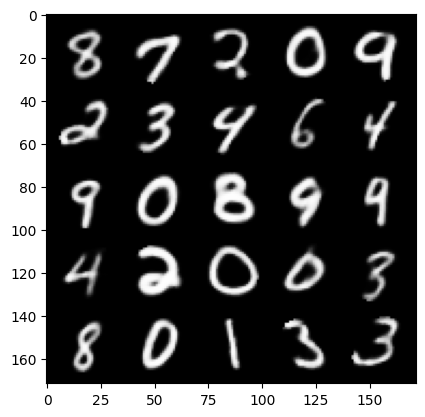

-------------------fake images------------------------


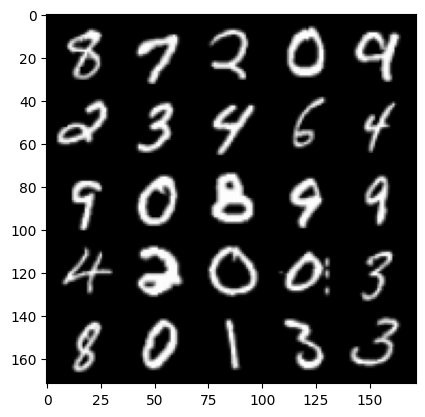

 31%|███       | 292/938 [00:07<00:16, 38.49it/s]

Epoch 37, step 35000: Generator loss: 0.07003356089070441, discriminator loss: 0.07003356089070441
-------------------fake images------------------------


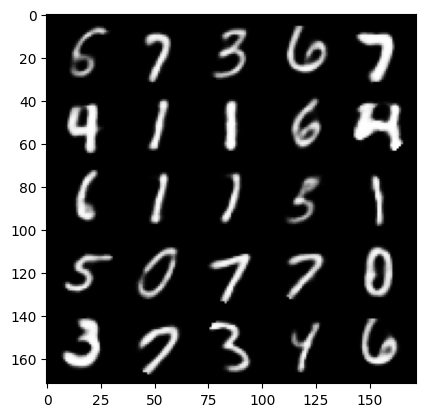

-------------------fake images------------------------


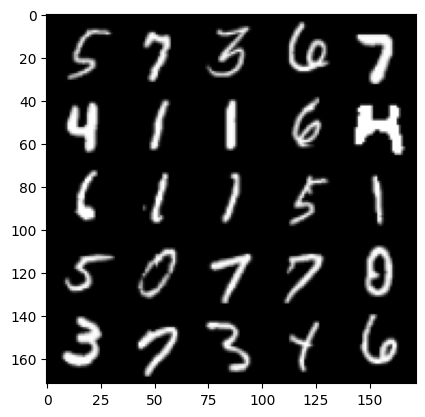

 64%|██████▍   | 602/938 [00:16<00:09, 36.75it/s]


KeyboardInterrupt: ignored

In [33]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    for i,(img,labels) in enumerate(tqdm(dataloader)):
        real_imgs = img.to(device)
        valid = torch.ones(real_imgs.size(0),1).to(device)
        fake = torch.zeros(real_imgs.size(0),1).to(device)

        #---------------
        #Train Generator
        #---------------
        optimizer_G.zero_grad()

        encoded_imgs = encoder(real_imgs)
        decoded_imgs = decoder(encoded_imgs)

        #loss measures ability of generator to fool discriminator
        g_loss = 0.001* adversarial_loss(discriminator(encoded_imgs),valid) + .999 * pixelwiseloss(decoded_imgs,real_imgs)

        g_loss.backward()
        optimizer_G.step()

        #-------------------
        #Train Discriminator
        #-------------------
        optimizer_D.zero_grad()

        #sampler noise as discriminator ground truth
        z = torch.randn(real_imgs.size(0),latent_dim).to(device)

        real_loss = adversarial_loss(discriminator(z),valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()),fake)

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()

        optimizer_D.step()

        # Keep track of the average discriminator loss
        mean_discriminator_loss += g_loss.item() / display_step
        # Keep track of the average generator loss

        mean_generator_loss += g_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            print('-------------------fake images------------------------')
            show_tensor_images(decoded_imgs)
            print('-------------------fake images------------------------')
            show_tensor_images(real_imgs)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
